<a href="https://colab.research.google.com/github/Tchouanga12/Face_Robustness/blob/main/Face_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adversarial pattern and covid masks agains facial recognition

The goal of this project is for you to experiment with the weaknesses of machine learning models and see by yourselves how easily they can be attacked (and defeated).

The goal of this project is to make you design a very simple version of an adversarial attack against a facial recognition model. 

### Rules and validation

In terms of validation, this assignement contains a mandatory part and some bonuses / extra work that requires more engagement to complete.

Basically if you do the bare minimum you can expect a 10/20, if you do what's mandatory you can expect around 15/20 and if you do more, take initiatives / add fun stuffs, you can definitly reach 20/20. I added some indications in the the last section about the grade you can expect to according what you've done.They are only indications and every initiative, additional remarks, example or explaination will be taken into account to your advantage. The goal is not only to do an actual attack but also for you to experiment and try to have fun "hacking" the system or find dangerous exploits related to these systems. I want you to realise how vulnerable these systems can be so you'll hopefully be more careful when designing and implementing them.

You can do this work alone or in group of two. You'll copy the notebook and name it "LASTNAME1-LASTNAME2-robustness" and share it with me directly on a google drive or by downloading it and sending it to me by email. In any case I expect an email with the link or the file.

You have the whole semester to do it and I expect it by the hand of the semester.

In case of cheating, copy/pasting others work, the mark will be divided by the number of copies of the same work.

For any questions you can reach me at darrin@aivancity.ai , make sure to add in the object of your email [Robustness] so it will be automatically sorted correctly.

You can write in french or in english, for any other languages please ask me first but mainly try to stick to french or english.

### Goal

Facial recognition is probably one of the most dangerous application of machine learnings technics and one of the most vulnerable. Several applications use it to provide a way to identify people. For example tinder offers a feature to check if the picture on an account are actual pictures (to avoid catfishing) or some online banks use it to automatically retrieve access to an accout when a client has lost his credentials. The goal of this project is for you to design a proof of concept of an attack to fool the facial recognition system to make it believe you're someone else.

Most of the time these applications ask you to strike different poses in the picture they take to ensure you are actually using your camera and not feeding the system with pictures of someone else. That's why you'll need to design an algorithm to modify your picture in a way that makes you look like someone else in they eye of the model.

We suppose that we have a function to extract a face from a larger image, and then a function $\operatorname{Sig}$ which built a signature in $R^d$ from the face. We then use the usual $L_2$ distance to compare faces. Better, we compare the new face to all the signatures of all the faces of the known personn.

$\operatorname{D}(X, \text{Person 1}) = \frac1{|\text{Person 1}|} \sum_{I \in \text{Person 1}} ||X - I||_2$

This notebook has been partially completed to give you a reasonable base to begin the project. You don't have to use everything I added to this notebook and do everything on your own if you want to.

### The facial recognition library

You'll use this https://github.com/timesler/facenet-pytorch implementation of facenet and advertorch https://advertorch.readthedocs.io/en/latest/ to generate adversarial attacks. 
For more advanced part of the project you'll probably have to implement adversarial attacks by yourselves but it's a good way to start.

Make sure you ask for a GPU environnement in colab by setting in `Execution > Change execution type` and select GPU.

In [61]:
!pip install facenet-pytorch ###Install facenet-pytorch (for facial recognition which uses pretrained neural networks)

!pip install git+https://github.com/BorealisAI/advertorch.git ##Install library which generates adversarial images

  Cloning https://github.com/BorealisAI/advertorch.git to /tmp/pip-req-build-xb671cbe
  Running command git clone -q https://github.com/BorealisAI/advertorch.git /tmp/pip-req-build-xb671cbe


In [62]:
# Some technical things

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') ##computational processing settings

In [63]:
device

device(type='cpu')

### Mounting a directory from google drive

You'll make a directory `projets/faceattack` `projets/faceattack/me` and `projets/faceattack/target`, you can do as many targets or me folders as you want if you want to impersonate different people. and in your google drive and we will use it to store the "datasets" you'll be using. Namely the pictures of the person you want to impersonate and your own.

You can decide to use your own faces or take any celebrities on the internet, you'll just have to put at least one picture for the target (several is better to have a more robust attack) and at least one picture to tamper with.

In [64]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
import os
import cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
PATH = Path('/content/drive/MyDrive/Aivancity/faceattack')

In [66]:
!ls '/content/drive/MyDrive/Aivancity/faceattack/me/me'

me.jpg			       WIN_20220206_15_17_36_Pro.jpg
WIN_20220206_14_16_33_Pro.jpg  WIN_20220206_15_17_38_Pro.jpg
WIN_20220206_15_17_33_Pro.jpg  WIN_20220206_15_17_41_Pro.jpg


In [67]:
label = ['me','target']

### Datasets and loading images


In [68]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms

class FolderDataset(Dataset):
  def __init__(self, dir : Path):
    self.paths = [dir / f for f in listdir(dir) if isfile(join(dir, f))] ##list of all image files with absolute path associated with them.

  def __getitem__(self, i):
    im = Image.open(self.paths[i]) ##open a particular image
    return np.array(im) ##returns a numpy array of image   
  
  def __len__(self):
    return len(self.paths) ##Number of images in the folder


# use to display pictures in google colab
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) ##saves img in buffer
    print('ret=', ret.shape)
    i = IPython.display.Image(data=ret) ##display image on google colab
    print('i=', i)
    IPython.display.display(i)

In [69]:
# Load each dataset using the class we just defined
target_dataset = FolderDataset(PATH / 'target/target')
me_dataset = FolderDataset(PATH / 'me/me')

In [70]:
imd =target_dataset.__getitem__(0)
print(imd[int(2):int(3), int(4):int(5), :])

[[[ 45  58 100]]]


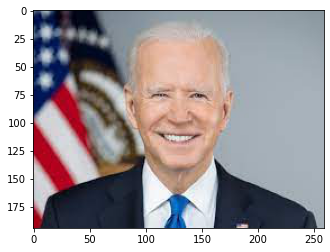

In [71]:
plt.imshow(imd)

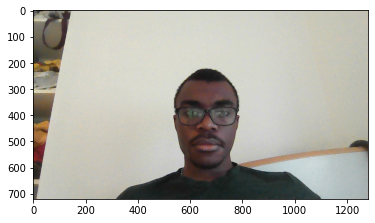

In [72]:
imd2= me_dataset.__getitem__(1)
plt.imshow(imd2)

### Facial recognition model

In [73]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization

# fixed_image_standardization is used to normalize a face 
# before feeding it to the resnet model

# Model used to detect faces in an image and to extract them
mtcnn = MTCNN(device=device, post_process = False)

# Model used to compare two faces and do the recognition part
resnet = InceptionResnetV1(classify=True, pretrained='vggface2').eval()

In [181]:
# Some utilities functions that you may need

# The mtcnn models returns boxes (x0, y0, x1, y1) in which the face should be
# contained
# Depending on the orientation of the image these might be permuted, this function
# makes sure that they are always in the same order
def permute_coords(img_shape, x0, y0, x1, y1):
  if img_shape[0] > img_shape[1]:
    return x0, y0, x1, y1
  else:
    return y0, x0, y1, x1

# This function crop and resize a face to normalize it so it can be fed to the
# recognition model
def crop_resize(im, box):
  x0, y0, x1, y1 = box
  crop = im[int(x0):int(x1), int(y0):int(y1), :]
  resize_fn = transforms.Resize((160, 160))
  crop = torch.Tensor(crop).transpose(0,2).transpose(1, 2)
  return resize_fn(crop).transpose(1,2).transpose(0,2).int()

# This function reverse the previous function
def revert_resize(im, box):
  resize_fn = transforms.Resize((int(abs(box[0] - box[2])), int(abs(box[1]-box[3]))))
  return resize_fn(im.transpose(0,2).transpose(1, 2).float()).transpose(1,2).transpose(0,2).int() 

##Function to add adversarial head
def insert_adverse(im, box, adverse):
  x0, y0, x1, y1 = box
  w,h,c = im[int(x0):int(x1), int(y0):int(y1), :].shape
  adverse=Image.fromarray(adverse,"RGB")
  adverse = adverse.resize((h,w))
  im[int(x0):int(x1), int(y0):int(y1), :] = adverse
  return im

##Function to add adversarial head
def insert(im, box, adverse):
  x0, y0, x1, y1 = box
  im[int(x0):int(x1-1), int(y0):int(y1-1), :] = adverse
  return im

### Some examples



> Extracting my face and plotting.



In [75]:
from re import L
# Extract my face

me_boxes = []
for i in range(len(me_dataset)):
  boxes, proba = mtcnn.detect(me_dataset[i])
  me_boxes.append(boxes[0])
  print('proba', proba)
  #print('[marks]:',_)
me_boxes = [permute_coords(im.shape, *me_boxes[k]) for k, im in enumerate(me_dataset)]


proba [0.9999399]
proba [0.9999399]
proba [0.99991226]
proba [0.9998387]
proba [0.997136]
proba [0.99999344 0.83387905]




> Visualizing output



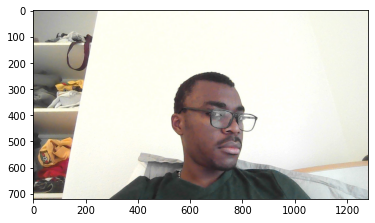

0


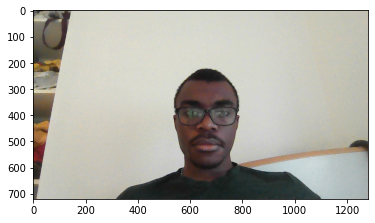

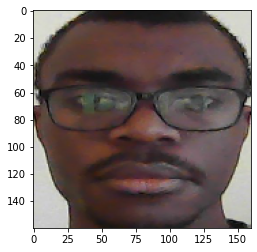

1


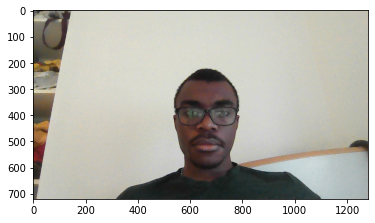

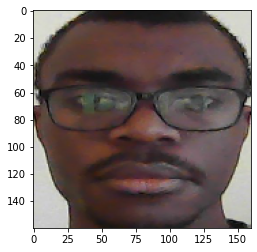

2


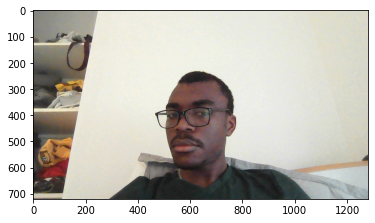

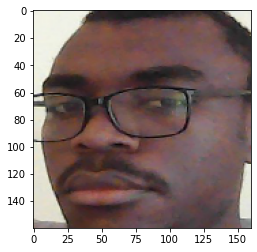

3


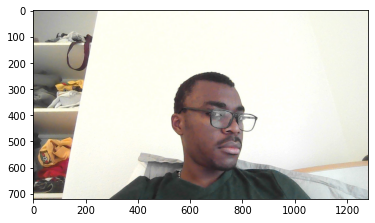

4


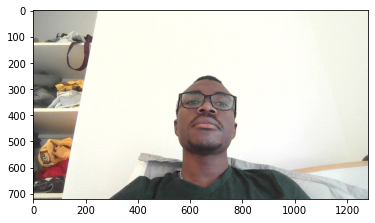

5


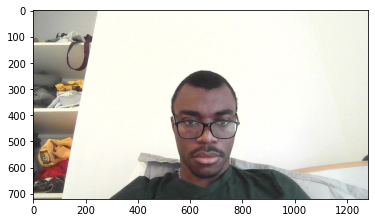

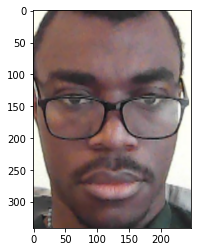

In [76]:
# Initial picture
plt.imshow(me_dataset[3])
plt.show()

# Resized and croppped
for i in range(len(me_dataset)):
  plt.subplots()
  print(i)
  plt.imshow(me_dataset[i])
  plt.show()
  cropped = crop_resize(me_dataset[i], me_boxes[i])
  plt.imshow(cropped)
  plt.show()


# Un-resized and croppped
im = revert_resize(cropped, me_boxes[0])
plt.imshow(im)
plt.show()

### Creating the signatures for the targeted face

In [77]:
## Create signatures / embeddings of the target face
signatures = []
target_boxes = []
face_target = []
for i in range(len(target_dataset)):
  boxes, proba = mtcnn.detect(target_dataset[i])
  target_boxes.append(boxes[0])
target_boxes = [permute_coords(im.shape, *target_boxes[k]) for k, im in enumerate(target_dataset)]

resnet = resnet.to(device)

for i in range(len(target_dataset)):
  cropped = crop_resize(target_dataset[i], target_boxes[i])
  im = fixed_image_standardization(cropped.float()).to(device)
  sig = resnet(im.transpose(0,2).transpose(1, 2).unsqueeze(0)).detach()
  signatures.append(sig.squeeze())
signatures = torch.stack(signatures)

In [78]:
## Create signatures / embeddings of the target face
signatures_me = []
me_boxes = []
face_me = []
face_me2 = []
for i in range(len(me_dataset)):
  boxes, proba = mtcnn.detect(me_dataset[i])
  me_boxes.append(boxes[0])
me_boxes = [permute_coords(im.shape, *me_boxes[k]) for k, im in enumerate(me_dataset)]

resnet = resnet.to(device)

for i in range(len(me_dataset)):
  cropped = crop_resize(me_dataset[i], me_boxes[i])
  im = fixed_image_standardization(cropped.float()).to(device)
  face_me.append(im.transpose(0,2).transpose(1, 2).unsqueeze(0))
  print(im.transpose(0,2).transpose(1, 2).unsqueeze(0).shape)
  sig1 = resnet(im.transpose(0,2).transpose(1, 2).unsqueeze(0)).detach()
  signatures_me.append(sig1.squeeze())
signatures_me = torch.stack(signatures_me)

torch.Size([1, 3, 160, 160])
torch.Size([1, 3, 160, 160])
torch.Size([1, 3, 160, 160])
torch.Size([1, 3, 160, 160])
torch.Size([1, 3, 160, 160])
torch.Size([1, 3, 160, 160])


**Note:** We observe a difference between the images from the me and target folder signals.

Signal view within images of the me folder

In [79]:
signatures_me[0].shape

torch.Size([8631])

Cross dimensional changes happening within the matrix computational difference calculcualtion

In [80]:
signatures.shape

torch.Size([9, 8631])

In [81]:
signatures.view(1, signatures.shape[0], signatures.shape[1]).shape

torch.Size([1, 9, 8631])

In [82]:
signatures.view(signatures.shape[0], 1, signatures.shape[1]).shape

torch.Size([9, 1, 8631])

# **Distance from me to target image**

Distance between points from the me target folder to that of the target folder images from which the mean is later on calculated in order to determine that distance.

$\operatorname{D}(X, \text{Person 1}) = \frac1{|\text{Person 1}|} \sum_{I \in \text{Person 1}} ||X - I||_2$

In the formula the X variable represents the adversarial image that has been created that is the difference with the 1 - dimensional array of the set of target images all combined together. 

In [83]:
# defining the loss function to make the adversarial attack
# average distance to the target faces signature
def loss_fn(x, signatures):
  signatures = signatures.detach()
  diff = x.view(x.shape[0], 1, x.shape[1]) - signatures.view(1, signatures.shape[0], signatures.shape[1]).to(device)
  return torch.norm(diff, dim=2).squeeze().mean()

In [84]:
x = signatures_me[0].unsqueeze(0)

In [85]:
signatures[0].shape

torch.Size([8631])

In [86]:
signatures.view(1, signatures.shape[0], signatures.shape[1]).shape

torch.Size([1, 9, 8631])

In [87]:
(x.view(x.shape[0], 1, x.shape[1]) - signatures.view(1, signatures.shape[0], signatures.shape[1])).shape

torch.Size([1, 9, 8631])

In [88]:
loss_fn(x, signatures)

tensor(317.6441)

# **Understanding of the distance calculation with a set of images**

To calculate the difference between one image in the target and the overall matrix containing the set of images. A compression is done over the overall matrix of the target images such that it fits a 1-dimensional array. 

This is then multiplied with the matrix of each image. 

Later on the norm is been calculated which evaluates the magnitude of each vector within the final matrix of each of the difference between the diverse images of the same set or folder.

In [89]:
# Distance between the different faces of the targeted personn
print(torch.norm(signatures.view(signatures.shape[0], 1, signatures.shape[1]) - signatures.view(1, signatures.shape[0], signatures.shape[1]), dim=2).mean())


tensor(124.2145)


# **Applying adversarial attacks**

This section implements the adversarial attack which will later on be compared using a matching mathematical method to similarity or proximity calculation.

In [90]:
from advertorch_examples.utils import bhwc2bchw
from advertorch_examples.utils import bchw2bhwc
import matplotlib.pyplot as plt
%matplotlib inline

**Model Selection**

Adversarial attack selection model.

**Note:** The evaluation function seems to have a serious impact on having the final softmax features from the CNN.

In [91]:
# For a model pretrained on CASIA-Webface
resnet2 = InceptionResnetV1(pretrained='casia-webface').eval()

Creating adversarial attack and visualizing the results.

**Resource:** https://advertorch-test.readthedocs.io/en/latest/_tutorials/tutorial_attack_defense_bpda_mnist.html#Perform-untargeted-attack

Many other adversarial attack exists and vary in the production of the adversarial images.

**Note:** Difference between targeted and untargeted attack.

- SparseL1DescentAttack
- LinfPGDAttack
- L2PGDAttack

In [92]:
from advertorch.attacks import SparseL1DescentAttack
from advertorch.attacks import LinfPGDAttack
from advertorch.attacks import L2PGDAttack
from advertorch.attacks import MomentumIterativeAttack
from advertorch.attacks  import LinfMomentumIterativeAttack
from advertorch.attacks  import L2MomentumIterativeAttack

##Function to convert tensor to numpy array
def retransform(tensor):
    advimg = tensor.squeeze().detach().transpose(1, 2).transpose(0,2)*128.0 + 127.5
    return  advimg.cpu().numpy()

def transform(cropped):
    im = fixed_image_standardization(cropped.float()).to(device)
    return im.transpose(0,2).transpose(1, 2).unsqueeze(0)

loss function in adversarial model
adversialimage use perturb (img, signature of target)

**SparseL1DescentAttack model**

adversarial attack production

In [93]:
adversary = SparseL1DescentAttack(
    resnet, loss_fn=loss_fn, eps=0.1,
    nb_iter=100, eps_iter=0.5, rand_init=True, clip_min=-1,
    targeted=False)

In [94]:
advimg1 = adversary.perturb(face_me[0],signatures)

In [95]:
advimgT = retransform(advimg1)

In [96]:
np_perturb = advimgT - retransform(face_me[0])

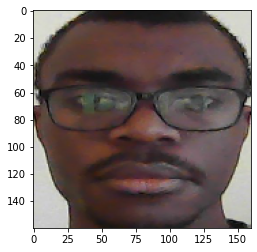

In [97]:
plt.imshow(retransform(face_me[0]).astype(int))



> Visualizing pertubation  effect 1.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


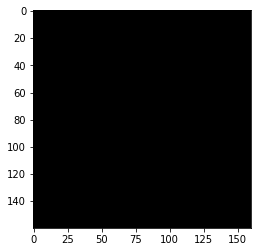

In [98]:
plt.imshow(np_perturb)

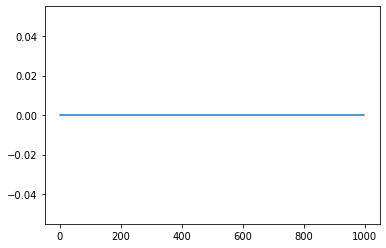

In [99]:
plt.plot(np_perturb.reshape(-1)[0:1000])

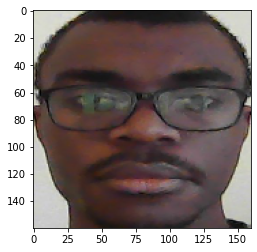

In [100]:
plt.imshow(advimgT.astype(int))



> Visualize pertubation on original image



In [101]:
resized_im = revert_resize(torch.from_numpy(advimgT),me_boxes[0])
im = insert(me_dataset[0],me_boxes[0],resized_im.numpy())
plt.imshow(im)

**LinfPGDAttack model**

adversarial attack production

In [103]:
adversary2 = LinfPGDAttack(
    resnet,loss_fn=loss_fn, eps=1./255, eps_iter=1./255*2/40, nb_iter=40,
    rand_init=False, targeted=False, clip_min=-1)

In [104]:
advimg2 = adversary2.perturb(face_me[0],signatures)

In [105]:
advimgT = retransform(advimg2)

In [106]:
np_perturb2 = advimgT - retransform(face_me[0])

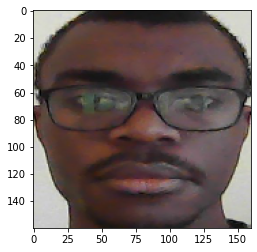

In [107]:
plt.imshow(retransform(face_me[0]).astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


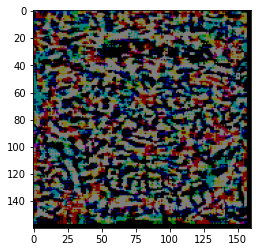

In [108]:
plt.imshow(np_perturb2)

In [109]:
plt.plot(np_perturb2.reshape(-1)[0:1000])

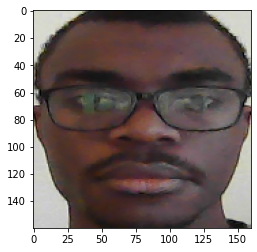

In [110]:
plt.imshow(advimgT.astype(int))

**L2PGDAttack**

adversarial attack production

In [111]:
adversary3 = L2PGDAttack(
    resnet, loss_fn=loss_fn, eps=0.15,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

In [112]:
advimg3 = adversary3.perturb(face_me[0],signatures)

In [113]:
advimgT = retransform(advimg3)

In [114]:
np_perturb3 = advimgT - retransform(face_me[0])

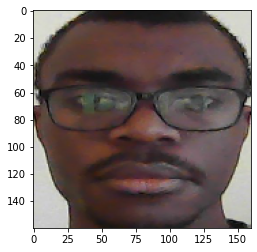

In [115]:
plt.imshow(retransform(face_me[0]).astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


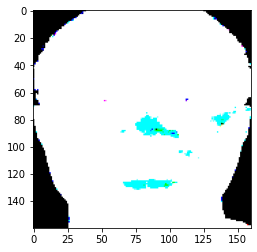

In [116]:
plt.imshow(np_perturb3)

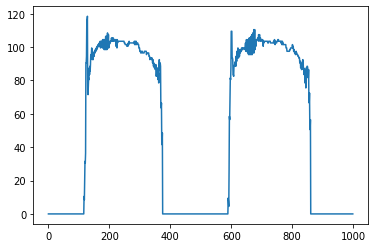

In [117]:
plt.plot(np_perturb3.reshape(-1)[0:1000])

In [118]:
plt.imshow(advimgT.astype(int))

In [180]:
resized_im = revert_resize(torch.from_numpy(advimgT),me_boxes[0])
im = insert(me_dataset[0],me_boxes[0],resized_im.numpy())
plt.imshow(im)

x0:  250.6285
y0:  538.7217
x1:  592.38403
y1:  786.10297
(341, 247, 3)


In [119]:

adversary4 = MomentumIterativeAttack(
    resnet, loss_fn=loss_fn, eps=0.08,
    nb_iter=40, eps_iter=0.01, 
    clip_min=0.0, clip_max=1.0,
    targeted=False)



**MomentumIterativeAttack Test**

In [120]:
"""
iter= [0.8,0.5,0.2, 0.1,0.01,0.001]

for i in iter:
  plt.subplots()
  adversary4 = MomentumIterativeAttack(
      resnet, loss_fn=loss_fn, eps=0.6,
      nb_iter=40, eps_iter=i, 
      clip_min=0.0, clip_max=1.0,
      targeted=False)

  advimg4 = adversary4.perturb(face_me[0],signatures)
  advimgT = retransform(advimg4)
  plt.imshow(advimgT.astype(int))
  plt.title(f'This the at epsilon {i}')
  """

"\niter= [0.8,0.5,0.2, 0.1,0.01,0.001]\n\nfor i in iter:\n  plt.subplots()\n  adversary4 = MomentumIterativeAttack(\n      resnet, loss_fn=loss_fn, eps=0.6,\n      nb_iter=40, eps_iter=i, \n      clip_min=0.0, clip_max=1.0,\n      targeted=False)\n\n  advimg4 = adversary4.perturb(face_me[0],signatures)\n  advimgT = retransform(advimg4)\n  plt.imshow(advimgT.astype(int))\n  plt.title(f'This the at epsilon {i}')\n  "

In [121]:
"""
eps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in iter:
  for j in eps:
    plt.subplots()
    adversary5 = L2MomentumIterativeAttack(
        resnet, loss_fn=loss_fn, eps=j,
        nb_iter=40, eps_iter=i, 
        clip_min=0.0, clip_max=1.0,
        targeted=False)

    advimg5 = adversary5.perturb(face_me[0],signatures)
    advimgT = retransform(advimg5)
    plt.imshow(advimgT.astype(int))
    plt.title(f'This the at epsilon {j} and iter {i}')
"""

"\neps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]\nfor i in iter:\n  for j in eps:\n    plt.subplots()\n    adversary5 = L2MomentumIterativeAttack(\n        resnet, loss_fn=loss_fn, eps=j,\n        nb_iter=40, eps_iter=i, \n        clip_min=0.0, clip_max=1.0,\n        targeted=False)\n\n    advimg5 = adversary5.perturb(face_me[0],signatures)\n    advimgT = retransform(advimg5)\n    plt.imshow(advimgT.astype(int))\n    plt.title(f'This the at epsilon {j} and iter {i}')\n"

In [122]:
"""
eps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in iter:
  for j in eps:
    plt.subplots()
    adversary5 = LinfMomentumIterativeAttack(
        resnet, loss_fn=loss_fn, eps=j,
        nb_iter=40, eps_iter=i, 
        clip_min=0.0, clip_max=1.0,
        targeted=False)

    advimg5 = adversary5.perturb(face_me[0],signatures)
    advimgT = retransform(advimg5)
    plt.imshow(advimgT.astype(int))
    plt.title(f'This the at epsilon {j} and iter {i}')
"""

"\neps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]\nfor i in iter:\n  for j in eps:\n    plt.subplots()\n    adversary5 = LinfMomentumIterativeAttack(\n        resnet, loss_fn=loss_fn, eps=j,\n        nb_iter=40, eps_iter=i, \n        clip_min=0.0, clip_max=1.0,\n        targeted=False)\n\n    advimg5 = adversary5.perturb(face_me[0],signatures)\n    advimgT = retransform(advimg5)\n    plt.imshow(advimgT.astype(int))\n    plt.title(f'This the at epsilon {j} and iter {i}')\n"

In [123]:
advimg4 = adversary4.perturb(face_me[0],signatures)

In [124]:
advimgT = retransform(advimg4)

In [125]:
np_perturb4 = advimgT - retransform(face_me[0])

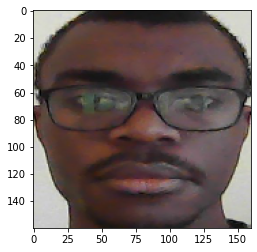

In [126]:
plt.imshow(retransform(face_me[0]).astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


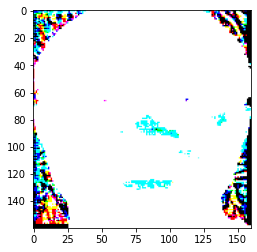

In [127]:
plt.imshow(np_perturb4)

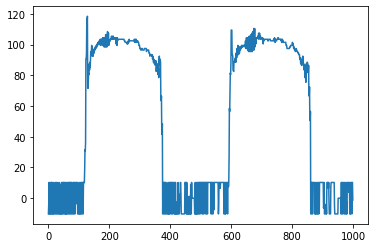

In [128]:
plt.plot(np_perturb4.reshape(-1)[0:1000])

In [129]:
plt.imshow(advimgT.astype(int))

# **Small processing of Adversarial image**

This phase contains  some processes done on the obtained adversarial image to produce the mapped feature to it for visualization to be done on it.

The action of unsqueeze upon squeeze giving two completely diverse results

In [130]:
sig1 = resnet(advimg1).detach()
sig2 = resnet(advimg2).detach()
sig3 = resnet(advimg3).detach()

# **Visualization**

Validating the correctness of the produced image.

<Figure size 720x360 with 0 Axes>

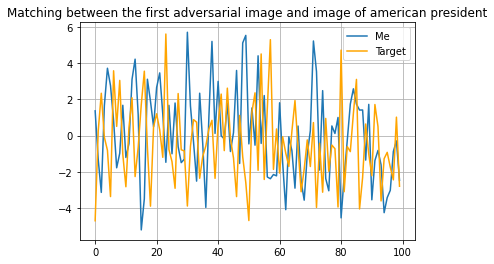

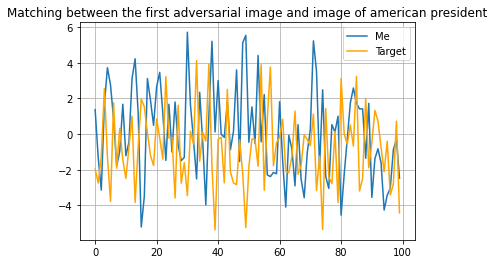

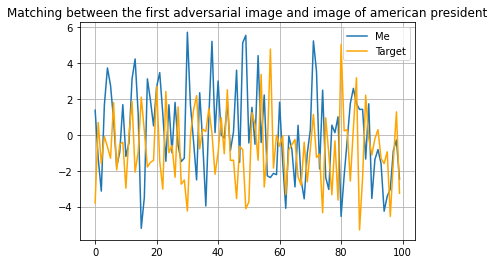

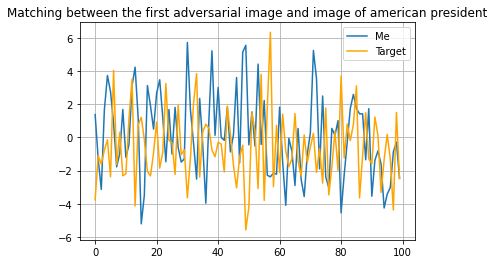

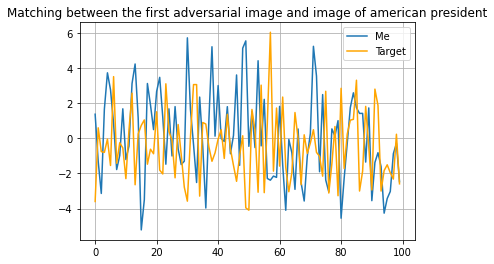

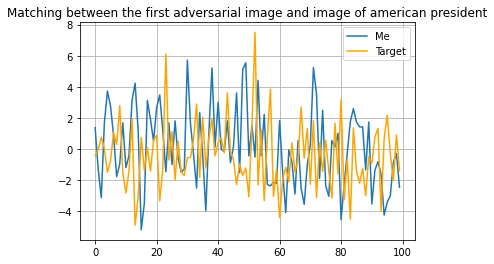

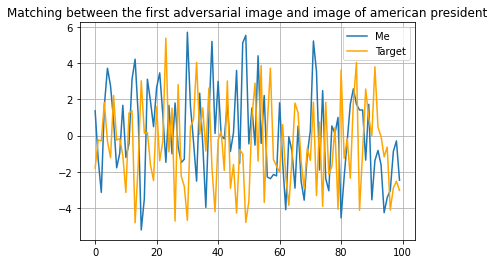

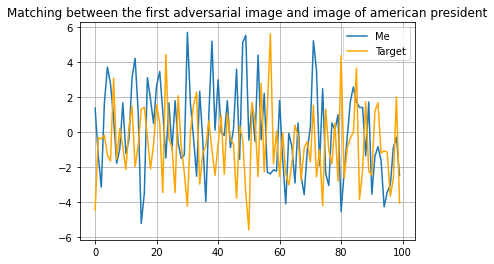

In [131]:
sigplot1=sig1.squeeze()
plt.figure(figsize=(10, 5))
for i in range(len(signatures)):
  plt.subplots()
  plt.title('Matching between the first adversarial image and image of american president')
  plt.plot(sigplot1[0:100], label='Me')
  plt.plot(signatures[i][0:100],color='orange', label='Target')
  plt.grid()
  plt.legend()

<Figure size 720x360 with 0 Axes>

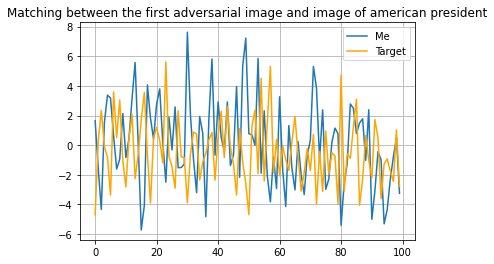

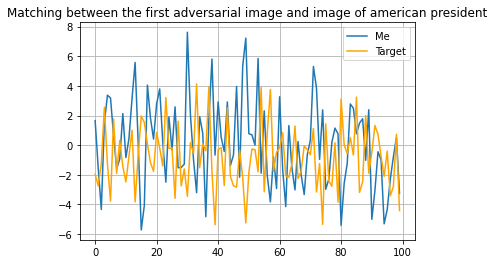

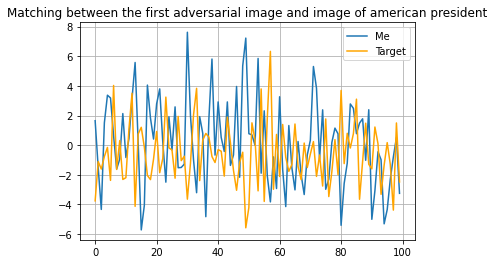

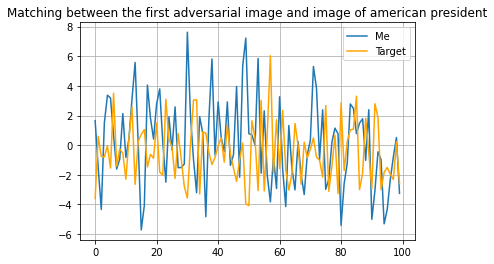

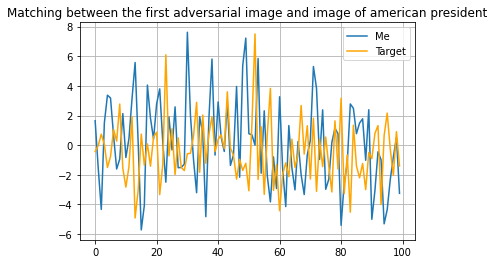

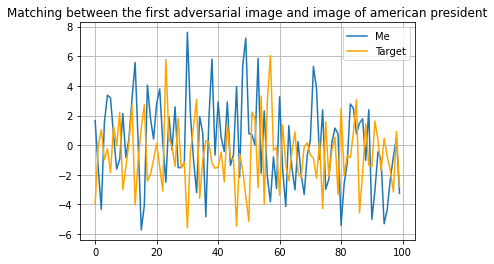

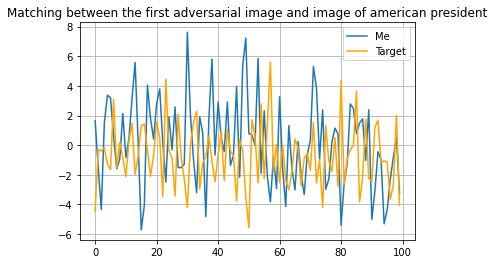

In [132]:
sigplot2=sig2.squeeze()
plt.figure(figsize=(10, 5))
for i in range(len(signatures)):
  plt.subplots()
  plt.title('Matching between the first adversarial image and image of american president')
  plt.plot(sigplot2[0:100], label='Me')
  plt.plot(signatures[i][0:100],color='orange', label='Target')
  plt.grid()
  plt.legend()

<Figure size 720x360 with 0 Axes>

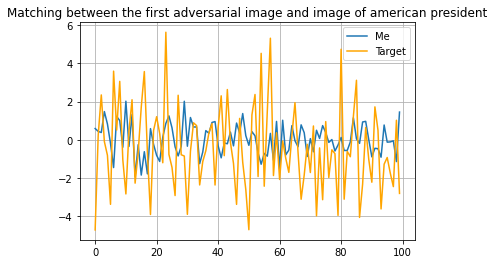

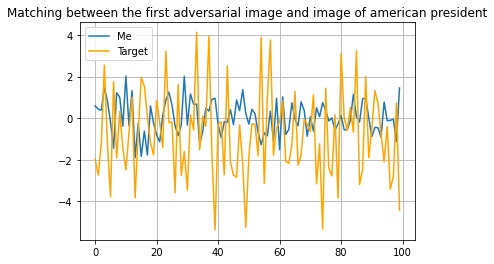

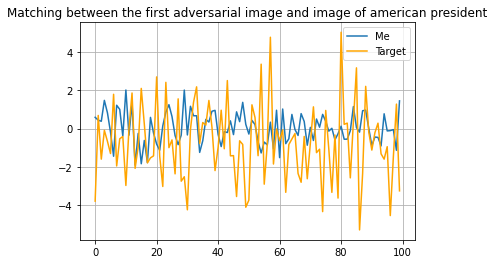

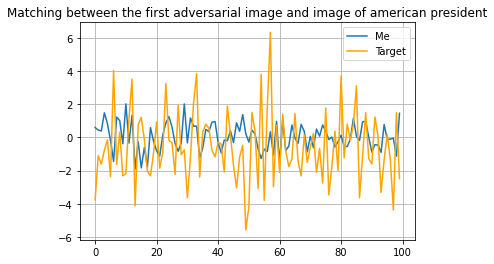

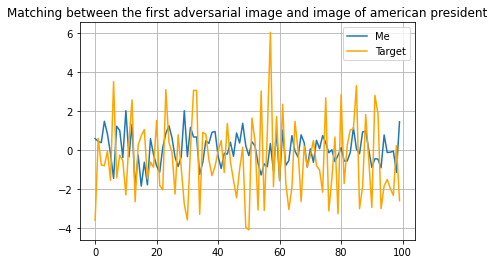

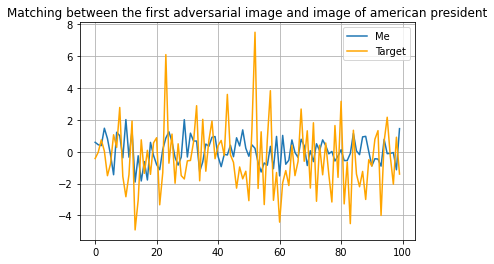

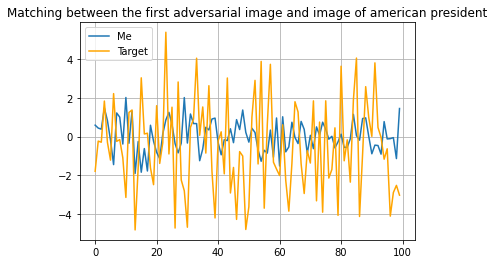

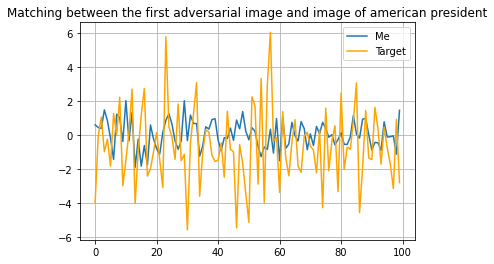

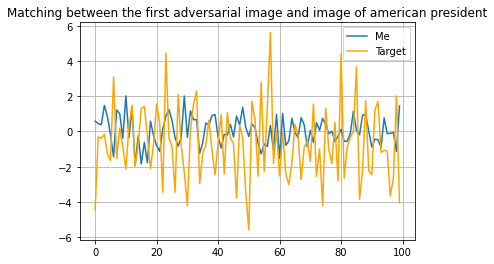

In [133]:
sigplot3=sig3.squeeze()
plt.figure(figsize=(10, 5))
for i in range(len(signatures)):
  plt.subplots()
  plt.title('Matching between the first adversarial image and image of american president')
  plt.plot(sigplot3[0:100], label='Me')
  plt.plot(signatures[i][0:100],color='orange', label='Target')
  plt.grid()
  plt.legend()

# **Norms verification**

We verify our results via the magnitude of both vectors space.

In [134]:
torch.norm(sig1)

tensor(224.6370)

In [135]:
torch.norm(signatures[0])

tensor(207.8483)

# **Inserting filter into image**

This phase entails inserting the  3 created adversarial attack onto the original me image itself.

In [136]:
newimg = insert_adverse(me_dataset[0],me_boxes[0],advimgT)

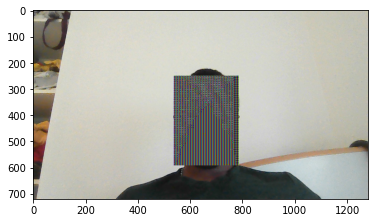

In [137]:
plt.imshow(newimg)

In [138]:
plt.imsave('adversefranck.jpg',newimg)

In [139]:
newimg2 = insert_adverse(me_dataset[0],me_boxes[0],np_perturb2.astype(int))

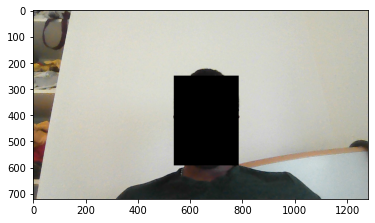

In [140]:
plt.imshow(newimg2)

In [141]:
plt.imsave('adversefranck2.jpg',newimg2)

In [142]:
newimg3 = insert_adverse(me_dataset[0],me_boxes[0],np_perturb3.astype(int))

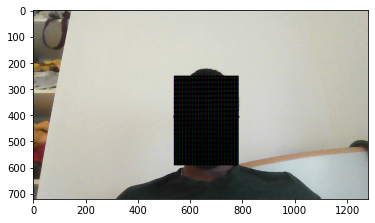

In [143]:
plt.imshow(newimg3)

In [144]:
plt.imsave('adversefranck3.jpg',newimg3)

## **Launch Your Camera**

Testing adversarial attack on real time camera tools.

In [145]:
"""
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
"""

"\nfrom IPython.display import display, Javascript\nfrom google.colab.output import eval_js\nfrom base64 import b64decode\n\ndef take_photo(filename='photo.jpg', quality=0.8):\n  js = Javascript('''\n    async function takePhoto(quality) {\n      const div = document.createElement('div');\n      const capture = document.createElement('button');\n      capture.textContent = 'Capture';\n      div.appendChild(capture);\n\n      const video = document.createElement('video');\n      video.style.display = 'block';\n      const stream = await navigator.mediaDevices.getUserMedia({video: true});\n\n      document.body.appendChild(div);\n      div.appendChild(video);\n      video.srcObject = stream;\n      await video.play();\n\n      // Resize the output to fit the video element.\n      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);\n\n      // Wait for Capture to be clicked.\n      await new Promise((resolve) => capture.onclick = resolve);\n\n      const canv

In [146]:
"""
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
"""

"\nfrom IPython.display import Image\ntry:\n  filename = take_photo()\n  print('Saved to {}'.format(filename))\n  \n  # Show the image which was just taken.\n  display(Image(filename))\nexcept Exception as err:\n  # Errors will be thrown if the user does not have a webcam or if they do not\n  # grant the page permission to access it.\n  print(str(err))\n"

## **Computing the distance of the me-edited picture and the me-original picture**


To detect a face in the edited picture of you and compute its distance to another picture of your face and its distance to the faces of the target (hint: it should now be closer to the other person than to you)

None


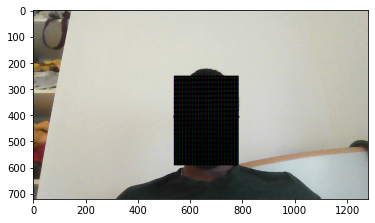

In [147]:
##Detect face in the transformed image of my face.
boxes, proba = mtcnn.detect(newimg3)
print(boxes)
plt.imshow(newimg3)

**1. Adversarial to me images distance**

Computing distance between adversarial image produced from diverse adversarial algorithms and computing this image with the images of the me folder

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

advData = list()

In [149]:
advData.append({'loss':float(loss_fn(sig1, signatures_me))})
advData.append({'loss':float(loss_fn(sig2, signatures_me))})
advData.append({'loss':float(loss_fn(sig3, signatures_me))})

In [150]:
df1 = pd.DataFrame(advData)
df1 = df1.sort_values(['loss'],ascending=False)

In [151]:
df1.sort_values(['loss'],ascending=False)

loss
2  230.872971
1  132.323990
0   90.457970

**2. Adversarial image to target images distance**

Computing the distance between the produced adversarial image from each adversarila production algorithm on the images of the target folder.

In [152]:
advData = list()
advData.append({'loss':float(loss_fn(sig1, signatures))})
advData.append({'loss':float(loss_fn(sig2, signatures))})
advData.append({'loss':float(loss_fn(sig3, signatures))})

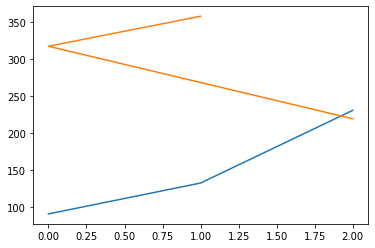

In [153]:
df2 = pd.DataFrame(advData)
df2 = df2.sort_values(['loss'],ascending=False)
plt.plot(df1.loss)
plt.plot(df2.loss)

In [154]:
loss_fn(sig1, signatures)

tensor(317.7208)

In [155]:
loss_fn(sig2, signatures)

tensor(358.3824)

In [156]:
loss_fn(sig3, signatures)

tensor(219.4862)

## **Fooling both models simultaneously**

Creating the diverse sets of signals using the second model

1. Creating the signals (collected from the softmax of the CNN) of the target image folder.

In [157]:
## Create signatures / embeddings of the target face
"""
signatures = []
target_boxes = []
face_target = []
for i in range(len(target_dataset)):
  boxes, proba = mtcnn.detect(target_dataset[i])
  target_boxes.append(boxes[0])
  print('proba', proba)
print('star: ',*target_boxes[0])
print('without star: ',target_boxes[0])
print('Type without star: ',type(target_boxes[0]))
target_boxes = [permute_coords(im.shape, *target_boxes[k]) for k, im in enumerate(target_dataset)]

resnet2 = resnet2.to(device)

for i in range(len(target_dataset)):
  cropped = crop_resize(target_dataset[i], target_boxes[i])
  face_target.append(cropped/255)
  im = fixed_image_standardization(cropped).to(device)
  print('im=',im.shape) 
  #print()
  sig = resnet2(im.transpose(0,2).transpose(1, 2).unsqueeze(0)).detach()
  signatures.append(sig.squeeze())
signatures = torch.stack(signatures)
"""

"\nsignatures = []\ntarget_boxes = []\nface_target = []\nfor i in range(len(target_dataset)):\n  boxes, proba = mtcnn.detect(target_dataset[i])\n  target_boxes.append(boxes[0])\n  print('proba', proba)\nprint('star: ',*target_boxes[0])\nprint('without star: ',target_boxes[0])\nprint('Type without star: ',type(target_boxes[0]))\ntarget_boxes = [permute_coords(im.shape, *target_boxes[k]) for k, im in enumerate(target_dataset)]\n\nresnet2 = resnet2.to(device)\n\nfor i in range(len(target_dataset)):\n  cropped = crop_resize(target_dataset[i], target_boxes[i])\n  face_target.append(cropped/255)\n  im = fixed_image_standardization(cropped).to(device)\n  print('im=',im.shape) \n  #print()\n  sig = resnet2(im.transpose(0,2).transpose(1, 2).unsqueeze(0)).detach()\n  signatures.append(sig.squeeze())\nsignatures = torch.stack(signatures)\n"

2. Creating the signals of the me image folder

In [158]:
## Create signatures / embeddings of the target face
"""
signatures_me = []
me_boxes = []
face_me = []
face_me2 = []
for i in range(len(me_dataset)):
  boxes, proba = mtcnn.detect(me_dataset[i])
  me_boxes.append(boxes[0])
  print('proba', proba)
me_boxes = [permute_coords(im.shape, *me_boxes[k]) for k, im in enumerate(me_dataset)]

resnet2 = resnet2.to(device)

for i in range(len(me_dataset)):
  cropped = crop_resize(me_dataset[i], me_boxes[i])
  im = fixed_image_standardization(cropped.float()).to(device)
  face_me.append(im.transpose(0,2).transpose(1, 2).unsqueeze(0))
  sig1 = resnet2(im.transpose(0,2).transpose(1, 2).unsqueeze(0)).detach()
  signatures_me.append(sig1.squeeze())
signatures_me = torch.stack(signatures_me)
"""

"\nsignatures_me = []\nme_boxes = []\nface_me = []\nface_me2 = []\nfor i in range(len(me_dataset)):\n  boxes, proba = mtcnn.detect(me_dataset[i])\n  me_boxes.append(boxes[0])\n  print('proba', proba)\nme_boxes = [permute_coords(im.shape, *me_boxes[k]) for k, im in enumerate(me_dataset)]\n\nresnet2 = resnet2.to(device)\n\nfor i in range(len(me_dataset)):\n  cropped = crop_resize(me_dataset[i], me_boxes[i])\n  im = fixed_image_standardization(cropped.float()).to(device)\n  face_me.append(im.transpose(0,2).transpose(1, 2).unsqueeze(0))\n  sig1 = resnet2(im.transpose(0,2).transpose(1, 2).unsqueeze(0)).detach()\n  signatures_me.append(sig1.squeeze())\nsignatures_me = torch.stack(signatures_me)\n"

# **Creating Facemask On Faces**

After reading the article https://arxiv.org/pdf/2111.10759.pdf . The following steps has been drafted  how the face mask adversarial attack could be implement using a metric called the cosine similarity score.

1. Getting the face landmarks.
2. Position a created mask on the mouth of the face.
3. creating adverattacks using the created facemask to match the target face.
4. Evaluate the quality of your facemask.
5. Add your facemask back to your face.

### **1. Get face landmarks**

In [159]:
boxes, proba, landmarks = mtcnn.detect(me_dataset[0],landmarks=True)
boxes = boxes[0]

In [160]:
boxes = permute_coords(me_dataset[0].shape, *boxes)

In this experiement phase the 3 last points will be used to draw the face mask out.

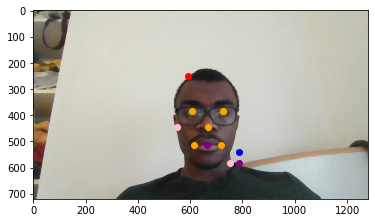

In [161]:
plt.imshow(me_dataset[0])
plt.plot(landmarks[0][0], color='yellow')
plt.scatter(landmarks[0][0][0], landmarks[0][0][1], color='orange')
plt.scatter(landmarks[0][1][0], landmarks[0][1][1],  color='orange')
plt.scatter(landmarks[0][2][0], landmarks[0][2][1],  color='orange')
plt.scatter(landmarks[0][3][0], landmarks[0][3][1],  color='orange')
plt.scatter(landmarks[0][4][0], landmarks[0][4][1],  color='orange')
plt.scatter(landmarks[0][3][0]+ abs(landmarks[0][3][0]-landmarks[0][4][0])/2 , landmarks[0][3][1] ,  color='purple')
plt.scatter(boxes[2], boxes[0], color='red')
plt.scatter(boxes[3], boxes[1],  color='blue')
plt.scatter(boxes[3], boxes[1] + abs(boxes[1]- abs(landmarks[0][4][1]+abs(landmarks[0][2][1] - landmarks[0][3][1]))) ,  color='purple')
plt.scatter(landmarks[0][2][0] - abs(landmarks[0][2][0] - boxes[3]), landmarks[0][2][1], color='pink')
plt.scatter(landmarks[0][4][0] + abs(landmarks[0][4][0] - boxes[3])/2, landmarks[0][4][1]+abs(landmarks[0][2][1] - landmarks[0][3][1]), color='pink')

Stating the points representing the shape of the mask draen on the face.

In [162]:
x1 = landmarks[0][2][0] - abs(landmarks[0][2][0] - boxes[3])
y1 = landmarks[0][2][1]
x2 = boxes[3]
y2 = boxes[1] + abs(boxes[1]- abs(landmarks[0][4][1]+abs(landmarks[0][2][1] - landmarks[0][3][1])))

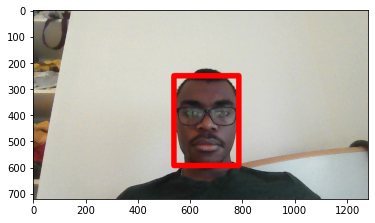

In [163]:
import cv2
boxes2 = permute_coords(me_dataset[0].shape, *boxes)
test = cv2.rectangle(me_dataset[0], (boxes2[0],boxes2[1]), (boxes2[2],boxes2[3]), (255,0,0), 20)
plt.imshow(test)

Permuting mask coordinates for proper adjustement of rectangular shape on the face to just capture the mouth section.

In [164]:
mask = [x1,y1, x2, y2]
print(mask)
mask = permute_coords(me_dataset[0].shape, *mask)

[548.4349, 444.1272, 786.10297, 581.88696]


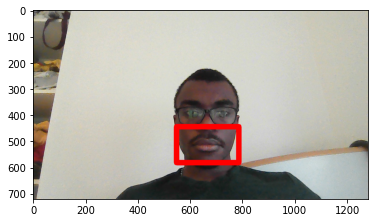

In [165]:
mask2 = permute_coords(me_dataset[0].shape, *mask)
test2 = cv2.rectangle(me_dataset[0], (mask2[2],mask2[3]), (mask2[0],mask2[1]), (255,0,0), 20)
plt.imshow(test2)

Drawing the mask upon the mouth section of the face.

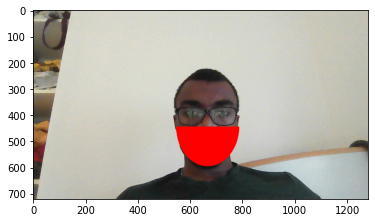

In [166]:
test3 =cv2.ellipse(me_dataset[0],(landmarks[0][2][0], landmarks[0][2][1]),(120,150),0,0,180,255,-1)
plt.imshow(test3)

Cropping the mask section from the face for adversarial mask creation.

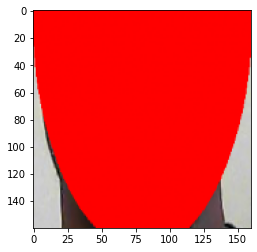

In [167]:
cropped = crop_resize(test3, mask)
plt.imshow(cropped)

Adversarial mask creation representing the target image.

In [168]:
cropped = transform(cropped)

In [169]:
mask_adv = adversary4.perturb(cropped,signatures)

In [170]:
mask_advT = retransform(mask_adv)

In [171]:
'''
try_ =  cv2.bitwise_or(me_dataset[0],test3)
plt.imshow(try_)
'''

'\ntry_ =  cv2.bitwise_or(me_dataset[0],test3)\nplt.imshow(try_)\n'

In [172]:
mask_adv_perturb = advimgT - retransform(cropped)

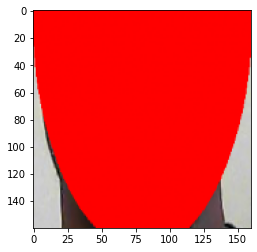

In [173]:
plt.imshow(retransform(cropped).astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


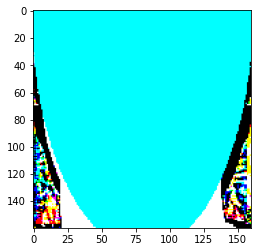

In [174]:
plt.imshow(mask_adv_perturb)

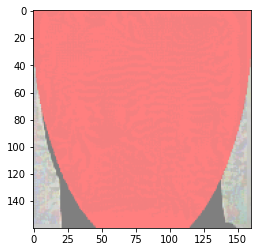

In [175]:
plt.imshow(mask_advT.astype(int))

In [176]:
resized_im = revert_resize(torch.from_numpy(mask_advT),mask)

In [177]:
resized_im.numpy().shape

(137, 237, 3)

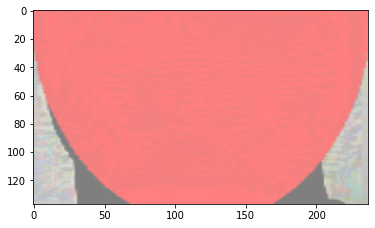

In [178]:
plt.imshow(resized_im.numpy())

In [179]:
im = insert(me_dataset[0],mask,resized_im.numpy())
#plt.imshow(im)

x0:  444.1272
y0:  548.4349
x1:  581.88696
y1:  786.10297
(136, 237, 3)


ValueError: ignored

In [ ]:
#mask_advT.shape

In [ ]:
def test(im, box):
#  resize_fn = transforms.Resize((int(abs(box[0] - box[2])+1), int(abs(box[1]-box[3])+1)))
#  return resize_fn(im.transpose(0,2).transpose(1, 2).float()).transpose(1,2).transpose(0,2).int() 

In [ ]:
#imgw = test(torch.Tensor(mask_advT),boxes)
#plt.imshow(imgw)

In [ ]:
#imgw.shape

In [ ]:
#x0, y0, x1, y1 = boxes
#test3[int(x0):int(x1), int(y0):int(y1), :] = imgw.numpy()

In [ ]:
#plt.imshow(cv2.bitwise_or(me_dataset[0],test3))

In [ ]:
#cropped_face = crop_resize(me_dataset[0], boxes)

## Your turn

Now that you have everything above you can begin working on your own.
- Find examples of actual use of facial recognition and how you could use this to attack it. 👍 
- Generate an adversarial attack to make the signature of your own face close to the signatures of the faces of the targeted person 👍 
- Get the modified face and paste it on your original pictures 👍 

These 3 firsts tasks are the bare minimum (10/20)

- Try different types of adversarial attacks to see the different results 👍 
- Attack another facial recognition model and compare the results  with VGG face("CASIA-Webface") 👍 
- Try (it should work) to detect a face in the edited picture of you and compute its distance to another picture of your face and its distance to the faces of the target (hint: it should now be closer to the other person than to you)

These next 3 constitute a good enough work (15/20) **NOT YET DONE**

- Try to fool both models at the same time

This point is a little bit more difficult but nothing really hard, you already have all the necessary code to do it and it will improve greatly the chances that your attack works in real life. (>= 16) **NOT YET DONE**

The next points are significantly more difficult and require more coding and engineering but can lead to print actual facemasks (~ 20/20) 👍  **ALMOST**
- Make an adversarial attack that creates a patch (a rectangle) on the mouth (like a facemask) with an adversarial patterns (and that do not modify all the face). [Optional]
- Print it, build your own mask and come in classs with it [Super Optional, actually more of joke but you can still try] (https://www.youtube.com/watch?v=_TXkDO5z11w)


Super advanced version of this assignement: https://arxiv.org/pdf/2111.10759.pdf